In [40]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import multiprocessing as mp
from tqdm import tqdm
from scipy.signal import detrend
from scipy.stats import linregress
import rioxarray as rxr
import torch
from copy import copy, deepcopy
import matplotlib
import cartopy 
import cartopy.crs as ccrs
import warnings
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
from scipy.io import loadmat

rcParams['font.family'] = 'Inter'
rcParams['font.size'] = 12
rcParams['figure.figsize'] = [5.0, 5.0]
rcParams['figure.dpi'] = 300
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

In [2]:
BASE_DIR = "AVHRR/"
LCREF_v3_DIR = "../../data/LCREF_v3.1/"
LCSIF_v3_DIR = "../../data/LCSIF_v3.1/"
SZA_DIR = "../../data/SZA/"
MVC_DIR = "AVHRR/data/AVHRR_MVC/"
fig_dir="./figs/"
DATA_DIR="../../data/"

In [3]:
def get_file_list(product_dir):
    filelist=[]
    for file in sorted(os.listdir(product_dir)):
        filelist.append(os.path.join(product_dir, file))
    return filelist

In [4]:
LCREF_FILE_LIST = [f for f in get_file_list(LCREF_v3_DIR) if "SNOW" in f]
LCSIF_FILE_LIST = [f for f in get_file_list(LCSIF_v3_DIR) if "SNOW" in f]
MVC_FILE_LIST = get_file_list(MVC_DIR)
SZA_FILE_LIST = get_file_list(SZA_DIR)
NAN_MASK=xr.open_dataset("../../data/processed/LCSIF_LCREF_MASK.nc").LCSIF_LCREF_MASK.values
growing_season_flag = np.invert(np.load("../../data/growing_season_monthly_flag.npy"))
area_weight=xr.open_dataset(os.path.join(DATA_DIR, "CMG_0.05Degree_Area_WGS84.nc")).area.values

In [5]:
def downsample_raster_data(raster_data, weight, bin_size=10, count_threshold = 0.5):
    with torch.no_grad():
        conv = torch.nn.Conv2d(1, 1, (bin_size,bin_size), bin_size, bias=False)
        conv.weight = torch.nn.Parameter(torch.ones_like(conv.weight))
        raster_data_tensor = torch.tensor(raster_data).expand(1, raster_data.shape[0], raster_data.shape[1]).float()
        weight_tensor = torch.tensor(weight).expand(1, 3600, 7200).float()
        weighted_raster_data_tensor = raster_data_tensor * weight_tensor
        weighted_count_tensor = np.invert(torch.isnan(raster_data_tensor)).type(torch.float) * weight_tensor
        weighted_raster_data_tensor[torch.isnan(raster_data_tensor)] = 0.0
        
        downsampled = conv(weighted_raster_data_tensor).numpy()[0]
        downsampled_weight = conv(weight_tensor).numpy()[0]
        downsampled_weighted_count= conv(weighted_count_tensor).numpy()[0]

    downsampled = downsampled / downsampled_weighted_count
    downsampled[downsampled_weighted_count < downsampled_weight * count_threshold] = np.nan
    return downsampled

In [6]:
def compute_annual_mean_from_biweekly(file_list, var_name="sif_clear_daily"):
    annual_mean_list=[]
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
        warnings.filterwarnings('ignore', r'Mean of empty (slice|axis)')
        for YEAR in tqdm(np.array(file_list).reshape(-1,24)):
            year_list=[]
            for i in range(12):
                first_half_month = xr.open_dataset(YEAR[i*2])[var_name].values[0]
                first_half_month[NAN_MASK]=np.nan
                second_half_month = xr.open_dataset(YEAR[i*2 + 1])[var_name].values[0]  
                second_half_month[NAN_MASK]=np.nan
                mvc = np.nanmax(np.stack([first_half_month, second_half_month]), axis=0)
                mvc[growing_season_flag[i, :, :]] = np.nan
                monthly_mean = np.nansum(mvc * area_weight) / np.nansum(area_weight[np.invert(np.isnan(mvc * area_weight))])
                year_list.append(monthly_mean)
            annual_mean_list.append(np.nanmean(year_list))
        return np.array(annual_mean_list)

In [7]:
red_weighted_spatial_annual_mean_list=compute_annual_mean_from_biweekly(LCREF_FILE_LIST, var_name="red")
nir_weighted_spatial_annual_mean_list=compute_annual_mean_from_biweekly(LCREF_FILE_LIST, var_name="nir")
sza_weighted_spatial_annual_mean_list=compute_annual_mean_from_biweekly(SZA_FILE_LIST, var_name="sza")

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 32/41 [05:43<01:35, 10.59s/it]


/tmp/ipykernel_2168458/613486736.py:15: RuntimeWarning: invalid value encountered in double_scalars
  monthly_mean = np.nansum(mvc * area_weight) / np.nansum(area_weight[np.invert(np.isnan(mvc * area_weight))])
/tmp/ipykernel_2168458/613486736.py:15: RuntimeWarning: invalid value encountered in double_scalars
  monthly_mean = np.nansum(mvc * area_weight) / np.nansum(area_weight[np.invert(np.isnan(mvc * area_weight))])
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [07:15<00:00, 10.62s/it]


In [8]:
red_weighted_spatial_annual_mean_list=red_weighted_spatial_annual_mean_list[0:32]
nir_weighted_spatial_annual_mean_list=nir_weighted_spatial_annual_mean_list[0:32]
sza_weighted_spatial_annual_mean_list=sza_weighted_spatial_annual_mean_list[0:32]

In [9]:
red_avhrr_annual_normalized_anomaly = (red_weighted_spatial_annual_mean_list - np.mean(red_weighted_spatial_annual_mean_list)) / np.mean(red_weighted_spatial_annual_mean_list)
red_avhrr_annual_normalized_anomaly_detrend = detrend(red_avhrr_annual_normalized_anomaly)

nir_avhrr_annual_normalized_anomaly = (nir_weighted_spatial_annual_mean_list - np.mean(nir_weighted_spatial_annual_mean_list)) / np.mean(nir_weighted_spatial_annual_mean_list)
nir_avhrr_annual_normalized_anomaly_detrend = detrend(nir_avhrr_annual_normalized_anomaly)

sza_avhrr_annual_normalized_anomaly = (sza_weighted_spatial_annual_mean_list - np.mean(sza_weighted_spatial_annual_mean_list)) / np.mean(sza_weighted_spatial_annual_mean_list)
sza_avhrr_annual_normalized_anomaly_detrend = detrend(sza_avhrr_annual_normalized_anomaly)


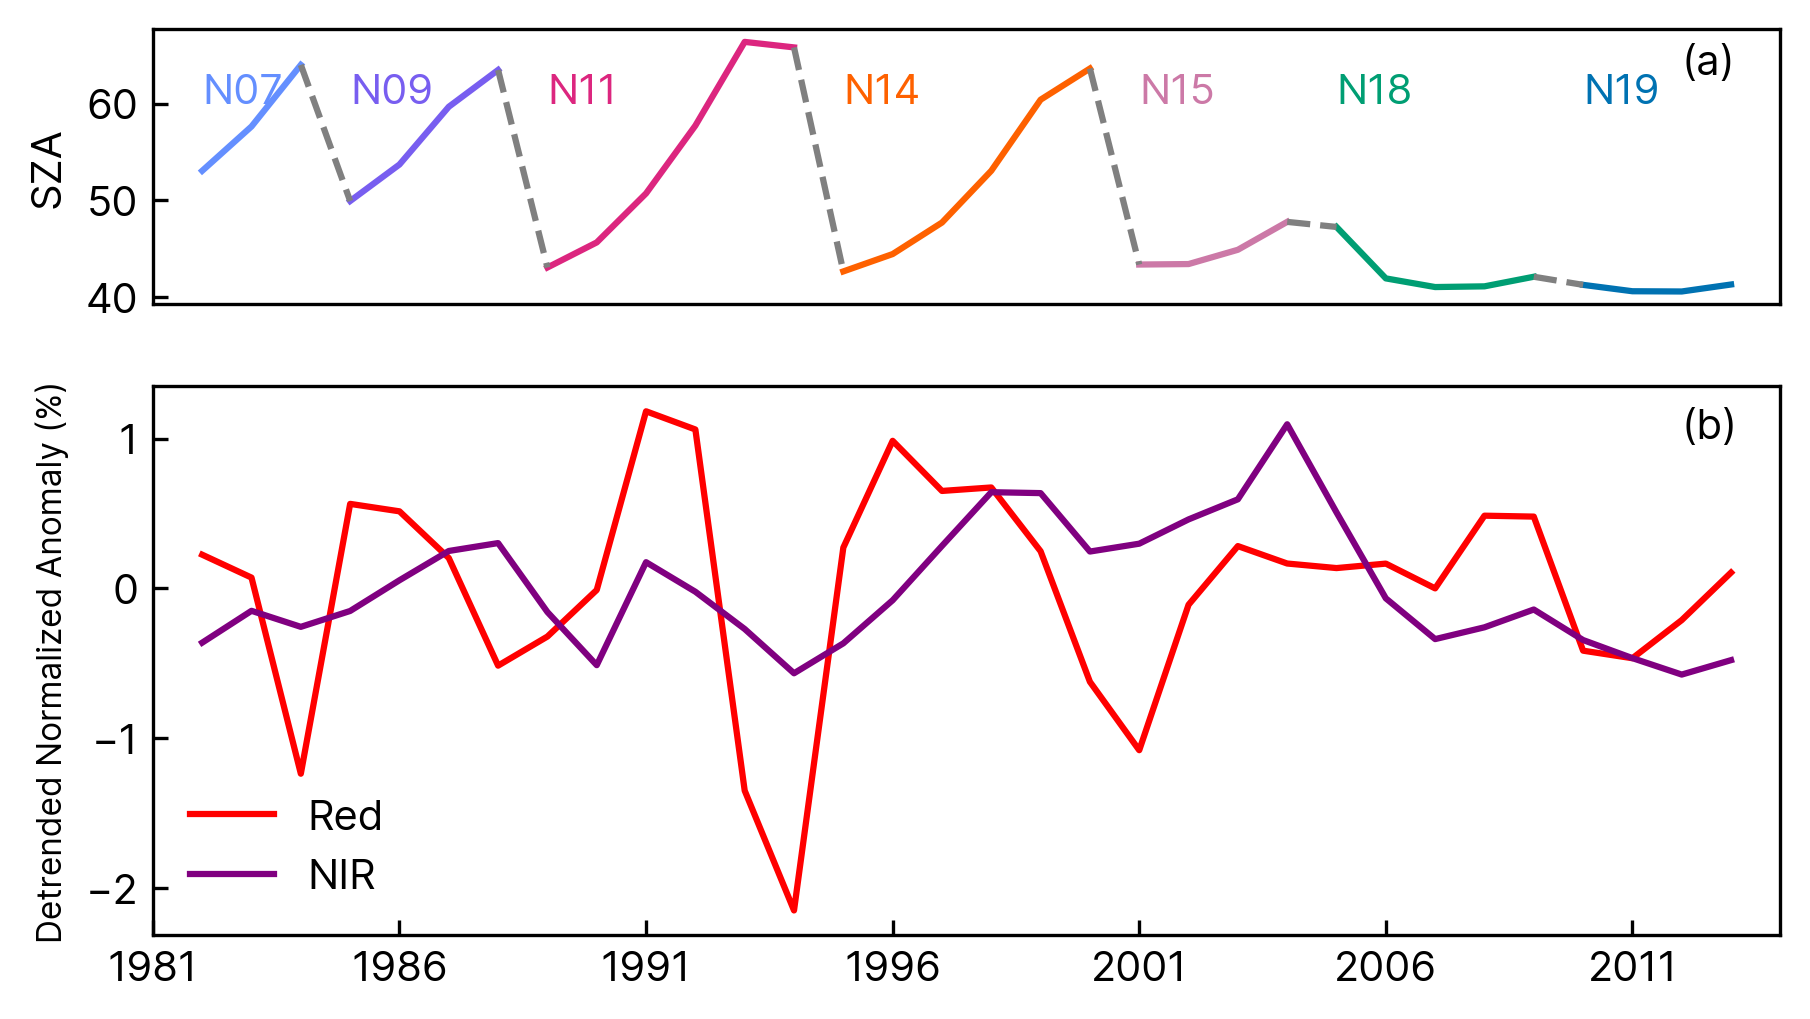

In [10]:
f, (ax1, ax2) = plt.subplots(2, 1,  gridspec_kw={'height_ratios': [1,2]}, figsize=(7,4), dpi=300)

ax1.plot(np.arange(1982, 2014)[0:3], sza_weighted_spatial_annual_mean_list[0:3], c="#648FFF", label="N07")
ax1.text(1982, 60, "N07", c="#648FFF")
ax1.plot(np.arange(1982, 2014)[3:7], sza_weighted_spatial_annual_mean_list[3:7], c="#785EF0", label="N09")
ax1.text(1985, 60, "N09", c="#785EF0")
ax1.plot(np.arange(1982, 2014)[7:13], sza_weighted_spatial_annual_mean_list[7:13], c="#DC267F", label="N11")
ax1.text(1989, 60, "N11", c="#DC267F")
ax1.plot(np.arange(1982, 2014)[13:19], sza_weighted_spatial_annual_mean_list[13:19], c="#FE6100", label="N14")
ax1.text(1995, 60, "N14", c="#FE6100")
ax1.plot(np.arange(1982, 2014)[19:23], sza_weighted_spatial_annual_mean_list[19:23], c="#CC79A7", label="N15")
ax1.text(2001, 60, "N15", c="#CC79A7")
ax1.plot(np.arange(1982, 2014)[23:28], sza_weighted_spatial_annual_mean_list[23:28], c="#009E73", label="N18")
ax1.text(2005, 60, "N18", c="#009E73")
ax1.plot(np.arange(1982, 2014)[28:], sza_weighted_spatial_annual_mean_list[28:], c="#0072B2", label="N19")
ax1.text(2010, 60, "N19", c="#0072B2")

ax1.plot(np.arange(1982, 2014)[2:4], sza_weighted_spatial_annual_mean_list[2:4], c="grey", linestyle="--")
ax1.plot(np.arange(1982, 2014)[6:8], sza_weighted_spatial_annual_mean_list[6:8], c="grey", linestyle="--")
ax1.plot(np.arange(1982, 2014)[12:14], sza_weighted_spatial_annual_mean_list[12:14], c="grey", linestyle="--")
ax1.plot(np.arange(1982, 2014)[18:20], sza_weighted_spatial_annual_mean_list[18:20], c="grey", linestyle="--")
ax1.plot(np.arange(1982, 2014)[22:24], sza_weighted_spatial_annual_mean_list[22:24], c="grey", linestyle="--")
ax1.plot(np.arange(1982, 2014)[27:29], sza_weighted_spatial_annual_mean_list[27:29], c="grey", linestyle="--")


ax1.set_xticks([])
ax1.set_ylabel("SZA")


ax2.plot(np.arange(1982, 2014), red_avhrr_annual_normalized_anomaly_detrend * 100, c="red", label="Red")
ax2.plot(np.arange(1982, 2014), nir_avhrr_annual_normalized_anomaly_detrend * 100, c="purple", label="NIR")
ax2.set_xticks([1981, 1986, 1991, 1996, 2001, 2006, 2011, 2016], ["1981", "1986", "1991", "1996", "2001", "2006", "2011", "2016"])
ax2.legend(frameon=False)
ax1.set_xlim(1981,2014)
ax2.set_xlim(1981,2014)
ax1.text(2012, 63, "(a)")
ax2.text(2012, 1, "(b)")

ax2.set_ylabel("Detrended Normalized Anomaly (%)", fontsize=8)
plt.savefig("./figs/Global_SZA_Reflectance_Anomaly.png")

In [11]:
def downsample_sif(sif, weight, count_threshold = 0.5):
    with torch.no_grad():
        conv = torch.nn.Conv2d(1, 1, (10,10), 10, bias=False)
        conv.weight = torch.nn.Parameter(torch.ones_like(conv.weight))
        sif_tensor = torch.tensor(sif).expand(1, 3600, 7200).float()
        weight_tensor = torch.tensor(weight).expand(1, 3600, 7200).float()
        weighted_sif_tensor = sif_tensor * weight_tensor
        weighted_count_tensor = np.invert(torch.isnan(sif_tensor)).type(torch.float) * weight_tensor
        weighted_sif_tensor[torch.isnan(sif_tensor)] = 0.0
        
        downsampled = conv(weighted_sif_tensor).numpy()[0]
        downsampled_weight = conv(weight_tensor).numpy()[0]
        downsampled_weighted_count= conv(weighted_count_tensor).numpy()[0]

    downsampled = downsampled / downsampled_weighted_count
    downsampled[downsampled_weighted_count < downsampled_weight * count_threshold] = np.nan
    return downsampled

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
        Input: Two xr.Datarrays of any dimensions with the first dim being time. 
        Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
        Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
        for y with respect to x.
        Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
        between the two datasets along their aligned time dimension.  
        Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount.
        Reference: https://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html
    """ 
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'Degrees of freedom <= 0 for slice')
        warnings.filterwarnings('ignore', r'invalid value encountered in sqrt')
    
        #1. Ensure that the data are properly alinged to each other. 
        x,y = xr.align(x,y)


        #2. Add lag information if any, and shift the data accordingly
        if lagx!=0:
            #If x lags y by 1, x must be shifted 1 step backwards. 
            #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
            x   = x.shift(time = -lagx).dropna(dim='time')
            #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
            x,y = xr.align(x,y)

        if lagy!=0:
            y   = y.shift(time = -lagy).dropna(dim='time')
            x,y = xr.align(x,y)

        #3. Compute data length, mean and standard deviation along time axis for further use: 
        #n     = x.shape[0]
        n = np.sum(np.invert(np.isnan(x.values)) & np.invert(np.isnan(y.values)), axis=0)
        xmean = x.mean(axis=0)
        ymean = y.mean(axis=0)
        xstd  = x.std(axis=0)
        ystd  = y.std(axis=0)

        #4. Compute covariance along time axis
        cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)

        #5. Compute correlation along time axis
        cor   = cov/(xstd*ystd)

        #6. Compute regression slope and intercept:
        slope     = cov/(xstd**2)
        intercept = ymean - xmean*slope  

        #7. Compute P-value and standard error
        #Compute t-statistics
        tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
        stderr = slope/tstats

        from scipy.stats import t
        pval   = t.sf(tstats, n-2)*2
        pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

        return cov,cor,slope,intercept,pval,stderr

In [12]:
red_annual_list=[]
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    warnings.filterwarnings('ignore', r'Mean of empty (slice|axis)')
    warnings.filterwarnings('ignore', r'invalid value encountered in divide')
    for YEAR in tqdm(np.array(LCREF_FILE_LIST).reshape(-1,24)[0:32]):
        year_list=[]
        for i in range(12):
            first_half_month = xr.open_dataset(YEAR[i*2]).red.values[0]
            first_half_month[NAN_MASK]=np.nan
            second_half_month = xr.open_dataset(YEAR[i*2 + 1]).red.values[0]
            second_half_month[NAN_MASK]=np.nan
            monthly_mvc = np.nanmax(np.stack([first_half_month, second_half_month]), axis=0)
            monthly_mvc[growing_season_flag[i, :, :]] = np.nan
            year_list.append(monthly_mvc)
        year_stack = np.stack(year_list)
        year_mean = np.nanmean(year_stack, axis=0)
        red_annual_list.append(downsample_sif(year_mean, area_weight))
red_avhrr_spatial_array = np.stack(red_annual_list, axis=0)
        
nir_annual_list=[]
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    warnings.filterwarnings('ignore', r'Mean of empty (slice|axis)')
    warnings.filterwarnings('ignore', r'invalid value encountered in divide')
    for YEAR in tqdm(np.array(LCREF_FILE_LIST).reshape(-1,24)[0:32]):
        year_list=[]
        for i in range(12):
            first_half_month = xr.open_dataset(YEAR[i*2]).nir.values[0]
            first_half_month[NAN_MASK]=np.nan
            second_half_month = xr.open_dataset(YEAR[i*2 + 1]).nir.values[0]
            second_half_month[NAN_MASK]=np.nan
            monthly_mvc = np.nanmax(np.stack([first_half_month, second_half_month]), axis=0)
            monthly_mvc[growing_season_flag[i, :, :]] = np.nan
            year_list.append(monthly_mvc)
        year_stack = np.stack(year_list)
        year_mean = np.nanmean(year_stack, axis=0)
        nir_annual_list.append(downsample_sif(year_mean, area_weight))
nir_avhrr_spatial_array = np.stack(nir_annual_list, axis=0)

        
sif_annual_list=[]
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    warnings.filterwarnings('ignore', r'Mean of empty (slice|axis)')
    warnings.filterwarnings('ignore', r'invalid value encountered in divide')
    for YEAR in tqdm(np.array(LCSIF_FILE_LIST).reshape(-1,24)[0:32]):
        year_list=[]
        for i in range(12):
            first_half_month = xr.open_dataset(YEAR[i*2]).sif_clear_daily.values[0]
            first_half_month[NAN_MASK]=np.nan
            second_half_month = xr.open_dataset(YEAR[i*2 + 1]).sif_clear_daily.values[0]
            second_half_month[NAN_MASK]=np.nan
            monthly_mvc = np.nanmax(np.stack([first_half_month, second_half_month]), axis=0)
            monthly_mvc[growing_season_flag[i, :, :]] = np.nan
            year_list.append(monthly_mvc)
        year_stack = np.stack(year_list)
        year_mean = np.nanmean(year_stack, axis=0)
        sif_annual_list.append(downsample_sif(year_mean, area_weight))
sif_avhrr_spatial_array = np.stack(sif_annual_list, axis=0)

        
        
sza_annual_list=[]
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
    warnings.filterwarnings('ignore', r'Mean of empty (slice|axis)')
    warnings.filterwarnings('ignore', r'invalid value encountered in divide')
    for YEAR in tqdm(np.array(SZA_FILE_LIST).reshape(-1,24)[0:32]):
        year_list=[]
        for i in range(12):
            first_half_month = xr.open_dataset(YEAR[i*2]).sza.values[0]
            first_half_month[NAN_MASK]=np.nan
            second_half_month = xr.open_dataset(YEAR[i*2 + 1]).sza.values[0]
            second_half_month[NAN_MASK]=np.nan
            monthly_mvc = np.nanmax(np.stack([first_half_month, second_half_month]), axis=0)
            monthly_mvc[growing_season_flag[i, :, :]] = np.nan
            year_list.append(monthly_mvc)
        year_stack = np.stack(year_list)
        year_mean = np.nanmean(year_stack, axis=0)
        sza_annual_list.append(downsample_sif(year_mean, area_weight))
sza_avhrr_spatial_array = np.stack(sza_annual_list, axis=0)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [04:54<00:00,  9.22s/it]


In [13]:
red_avhrr_spatial_da = xr.DataArray(red_avhrr_spatial_array, dims=["time", "lat", "lon"], coords={"time":np.arange(1982, 2014),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
red_avhrr_spatial_time_da = xr.DataArray(np.stack([np.full((360,720), i).astype(np.float32) for i in red_avhrr_spatial_da.time]), dims=["time", "lat", "lon"], coords={"time":red_avhrr_spatial_da.time,
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
nir_avhrr_spatial_da = xr.DataArray(nir_avhrr_spatial_array, dims=["time", "lat", "lon"], coords={"time":np.arange(1982, 2014),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
nir_avhrr_spatial_time_da = xr.DataArray(np.stack([np.full((360,720), i).astype(np.float32) for i in nir_avhrr_spatial_da.time]), dims=["time", "lat", "lon"], coords={"time":red_avhrr_spatial_da.time,
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
sif_avhrr_spatial_da = xr.DataArray(sif_avhrr_spatial_array, dims=["time", "lat", "lon"], coords={"time":np.arange(1982, 2014),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
sif_avhrr_spatial_time_da = xr.DataArray(np.stack([np.full((360,720), i).astype(np.float32) for i in sif_avhrr_spatial_da.time]), dims=["time", "lat", "lon"], coords={"time":red_avhrr_spatial_da.time,
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
sza_avhrr_spatial_da = xr.DataArray(sza_avhrr_spatial_array, dims=["time", "lat", "lon"], coords={"time":np.arange(1982, 2014),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
sza_avhrr_spatial_time_da = xr.DataArray(np.stack([np.full((360,720), i).astype(np.float32) for i in sza_avhrr_spatial_da.time]), dims=["time", "lat", "lon"], coords={"time":red_avhrr_spatial_da.time,
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
red_avhrr_cov,red_avhrr_cor,red_avhrr_slope,red_avhrr_intercept,red_avhrr_pval,red_avhrr_stderr = lag_linregress_3D(red_avhrr_spatial_time_da, red_avhrr_spatial_da)
nir_avhrr_cov,nir_avhrr_cor,nir_avhrr_slope,nir_avhrr_intercept,nir_avhrr_pval,nir_avhrr_stderr = lag_linregress_3D(nir_avhrr_spatial_time_da, nir_avhrr_spatial_da)
sif_avhrr_cov,sif_avhrr_cor,sif_avhrr_slope,sif_avhrr_intercept,sif_avhrr_pval,sif_avhrr_stderr = lag_linregress_3D(sif_avhrr_spatial_time_da, sif_avhrr_spatial_da)
sza_avhrr_cov,sza_avhrr_cor,sza_avhrr_slope,sza_avhrr_intercept,sza_avhrr_pval,sza_avhrr_stderr = lag_linregress_3D(sza_avhrr_spatial_time_da, sza_avhrr_spatial_da)



In [14]:
def detrend_raster(data_array, slope_array, intercept_array):
    detrended = deepcopy(data_array)
    for i in range(data_array.shape[0]):
        detrended[i, :, :] = detrended[i, :, :] - ((i + 1982) * slope_array + intercept_array)
    return detrended

In [15]:
red_avhrr_spatial_detrend = detrend_raster(red_avhrr_spatial_array, red_avhrr_slope.values, red_avhrr_intercept.values)
nir_avhrr_spatial_detrend = detrend_raster(nir_avhrr_spatial_array, nir_avhrr_slope.values, nir_avhrr_intercept.values)
sza_avhrr_spatial_detrend = detrend_raster(sza_avhrr_spatial_array, sza_avhrr_slope.values, sza_avhrr_intercept.values)
sif_avhrr_spatial_detrend = detrend_raster(sif_avhrr_spatial_array, sif_avhrr_slope.values, sif_avhrr_intercept.values)

In [16]:
red_avhrr_spatial_detrend_da = xr.DataArray(red_avhrr_spatial_detrend, dims=["time", "lat", "lon"], coords={"time":np.arange(1982,2014),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})

nir_avhrr_spatial_detrend_da = xr.DataArray(nir_avhrr_spatial_detrend, dims=["time", "lat", "lon"], coords={"time":np.arange(1982,2014),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})

sza_avhrr_spatial_detrend_da = xr.DataArray(sza_avhrr_spatial_detrend, dims=["time", "lat", "lon"], coords={"time":np.arange(1982,2014),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})
sif_avhrr_spatial_detrend_da = xr.DataArray(sif_avhrr_spatial_detrend, dims=["time", "lat", "lon"], coords={"time":np.arange(1982,2014),
                                            "lat":np.flip(np.arange(-89.75,90, 0.5)),
                                            "lon":np.arange(-179.75, 180, 0.5)})

In [17]:
def plot_pattern(fig, ax1, ax2, data_mat, p_val, text_str, cor=False, bound_norm_list=None, bound_norm_tick=None, bound_norm_tick_label=None, lat_xlim=None, lat_norm_tick=None, lat_norm_tick_label=None):
    count_too_small = 720 - np.sum(np.isnan(data_mat), axis=1) < 25
    
    if not cor or bound_norm_list is not None:
        data_mat_mean = np.nanmean(data_mat, axis=1)
        lower_ribbon = (data_mat_mean-np.nanstd(data_mat, axis=1))
        upper_ribbon = (data_mat_mean+np.nanstd(data_mat, axis=1))
    else:
        data_mat_mean = np.nanmean(data_mat, axis=1)
        lower_ribbon = (data_mat_mean-np.nanstd(data_mat, axis=1))
        upper_ribbon = (data_mat_mean+np.nanstd(data_mat, axis=1))
        
        data_mat_mean[count_too_small] = np.nan
        lower_ribbon[count_too_small] = np.nan
        upper_ribbon[count_too_small] = np.nan
        

    ax1.fill_betweenx(np.flip(np.arange(-89.75,90, 0.5)),
                      lower_ribbon, upper_ribbon, color="lightgray")
    ax1.plot(data_mat_mean, np.flip(np.arange(-89.75,90, 0.5)), color="darkmagenta")
    
    if not cor:
        if lat_xlim is not None:
            ax1.set_xlim(lat_xlim[0], lat_xlim[1])
            ax1.set_xticks(lat_norm_tick, lat_norm_tick_label)
        else:
            ax1.set_xlim(-0.015, 0.015)
            ax1.set_xticks([-0.01, 0, 0.01], ['-0.01', '0', '0.01'])
        ax1.set_yticks([90, 60, 30, 0, -30, -60, -90], ['90$^{\circ}N$', '60$^{\circ}N$', '30$^{\circ}N$', '0$^{\circ}$', '30$^{\circ}S$', '60$^{\circ}S$', '90$^{\circ}S$'])
        ax1.set_ylim(-90, 90)

    else:
        ax1.set_xlim(-0.04,0.04)
        ax1.set_xticks([-0.03, 0.03], ['-0.03', '0.03'])
        ax1.set_yticks([90, 60, 30, 0, -30, -60, -90], ['90$^{\circ}N$', '60$^{\circ}N$', '30$^{\circ}N$', '0$^{\circ}$', '30$^{\circ}S$', '60$^{\circ}S$', '90$^{\circ}S$'])
        ax1.set_ylim(-90, 90)
        

    if not cor:
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkmagenta","white", "darkgreen"])
        if bound_norm_list is not None:
            norm=matplotlib.colors.BoundaryNorm(bound_norm_list, matplotlib.cm.viridis.N, extend='max')
            im2=ax2.imshow(data_mat, transform=ccrs.PlateCarree(), aspect='auto', extent=[-180,180,-90,90],interpolation="none", norm=norm, cmap="viridis")
            cbar = fig.colorbar(im2, ax=ax2, orientation="vertical", fraction=0.027, ticks=bound_norm_tick)
            cbar.ax.set_yticklabels(bound_norm_tick_label)
        else:
            norm=matplotlib.colors.BoundaryNorm([-0.03, -0.025, -0.02, -0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03], matplotlib.cm.hot.N, extend='both')
            im2=ax2.imshow(data_mat * 10, transform=ccrs.PlateCarree(), aspect='auto', extent=[-180,180,-90,90],interpolation="none", norm=norm, cmap=cmap)
            cbar = fig.colorbar(im2, ax=ax2, orientation="vertical", fraction=0.027, ticks=[-0.03,-0.02, -0.01, 0, 0.01, 0.02, 0.03])
            cbar.ax.set_yticklabels(['-0.03', '-0.02', '-0.01', '0', '0.01', '0.02', '0.03'])
        
    else:
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","yellow", "darkred"])
        norm=matplotlib.colors.BoundaryNorm([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1], matplotlib.cm.hot.N)
        im2=ax2.imshow(data_mat, transform=ccrs.PlateCarree(), aspect='auto', extent=[-180,180,-90,90],interpolation="none", cmap="bwr", norm=norm)
        cbar = fig.colorbar(im2, ax=ax2, orientation="vertical", fraction=0.027, ticks=[-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
        cbar.ax.set_yticklabels(["-1", "-0.8", "-0.6", "-0.4", "-0.2", "0", "0.2", "0.4", "0.6", "0.8", "1"])
        
    ax2.add_feature(cartopy.feature.OCEAN, zorder=0, color="white")
    ax2.coastlines()
    gl=ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.right_labels=False
    gl.top_labels=False
    gl.left_labels=False

    if not (p_val is None):
        ax2.contourf(np.arange(-179.75, 180, 0.5), np.flip(np.arange(-89.75,90, 0.5)), p_val < 0.05, levels=1,
                          colors="white", hatches=['', '...'] , extend='neither', alpha=0)
    ax2.text(-180, 95, text_str, fontsize=25)

In [18]:
red_sza_avhrr_cov,red_sza_avhrr_cor,red_sza_avhrr_slope,red_sza_avhrr_intercept,red_sza_avhrr_pval,red_sza_avhrr_stderr = lag_linregress_3D(red_avhrr_spatial_detrend_da, sza_avhrr_spatial_detrend_da)
nir_sza_avhrr_cov,nir_sza_avhrr_cor,nir_sza_avhrr_slope,nir_sza_avhrr_intercept,nir_sza_avhrr_pval,nir_sza_avhrr_stderr = lag_linregress_3D(nir_avhrr_spatial_detrend_da, sza_avhrr_spatial_detrend_da)
sif_sza_avhrr_cov,sif_sza_avhrr_cor,sif_sza_avhrr_slope,sif_sza_avhrr_intercept,sif_sza_avhrr_pval,sif_sza_avhrr_stderr = lag_linregress_3D(sif_avhrr_spatial_detrend_da, sza_avhrr_spatial_detrend_da)

In [19]:
LOW_SIF_MASK = np.load("../../data/processed/low_sif_mask_0.03.npy")

red_sza_avhrr_cov_masked = copy(red_sza_avhrr_cov.values)
red_sza_avhrr_cov_masked[LOW_SIF_MASK] = np.nan

nir_sza_avhrr_cov_masked = copy(nir_sza_avhrr_cov.values)
nir_sza_avhrr_cov_masked[LOW_SIF_MASK] = np.nan

sif_sza_avhrr_cov_masked= copy(sif_sza_avhrr_cov.values)
sif_sza_avhrr_cov_masked[LOW_SIF_MASK] = np.nan

red_sza_avhrr_pval_masked = copy(red_sza_avhrr_pval.values)
red_sza_avhrr_pval_masked[LOW_SIF_MASK] = np.nan

nir_sza_avhrr_pval_masked = copy(nir_sza_avhrr_pval.values)
nir_sza_avhrr_pval_masked[LOW_SIF_MASK] = np.nan

sif_sza_avhrr_pval_masked = copy(sif_sza_avhrr_pval.values)
sif_sza_avhrr_pval_masked[LOW_SIF_MASK] = np.nan

/burg/glab/users/jf3423/.conda/envs/jianing/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2168458/3890633965.py:3: RuntimeWarning: Mean of empty slice
  sza_coeff_variation = np.nanstd(sza_avhrr_spatial_array, axis=0) / np.nanmean(sza_avhrr_spatial_array, axis=0)
/tmp/ipykernel_2168458/3167144657.py:9: RuntimeWarning: Mean of empty slice
  data_mat_mean = np.nanmean(data_mat, axis=1)
/tmp/ipykernel_2168458/3167144657.py:5: RuntimeWarning: Mean of empty slice
  data_mat_mean = np.nanmean(data_mat, axis=1)


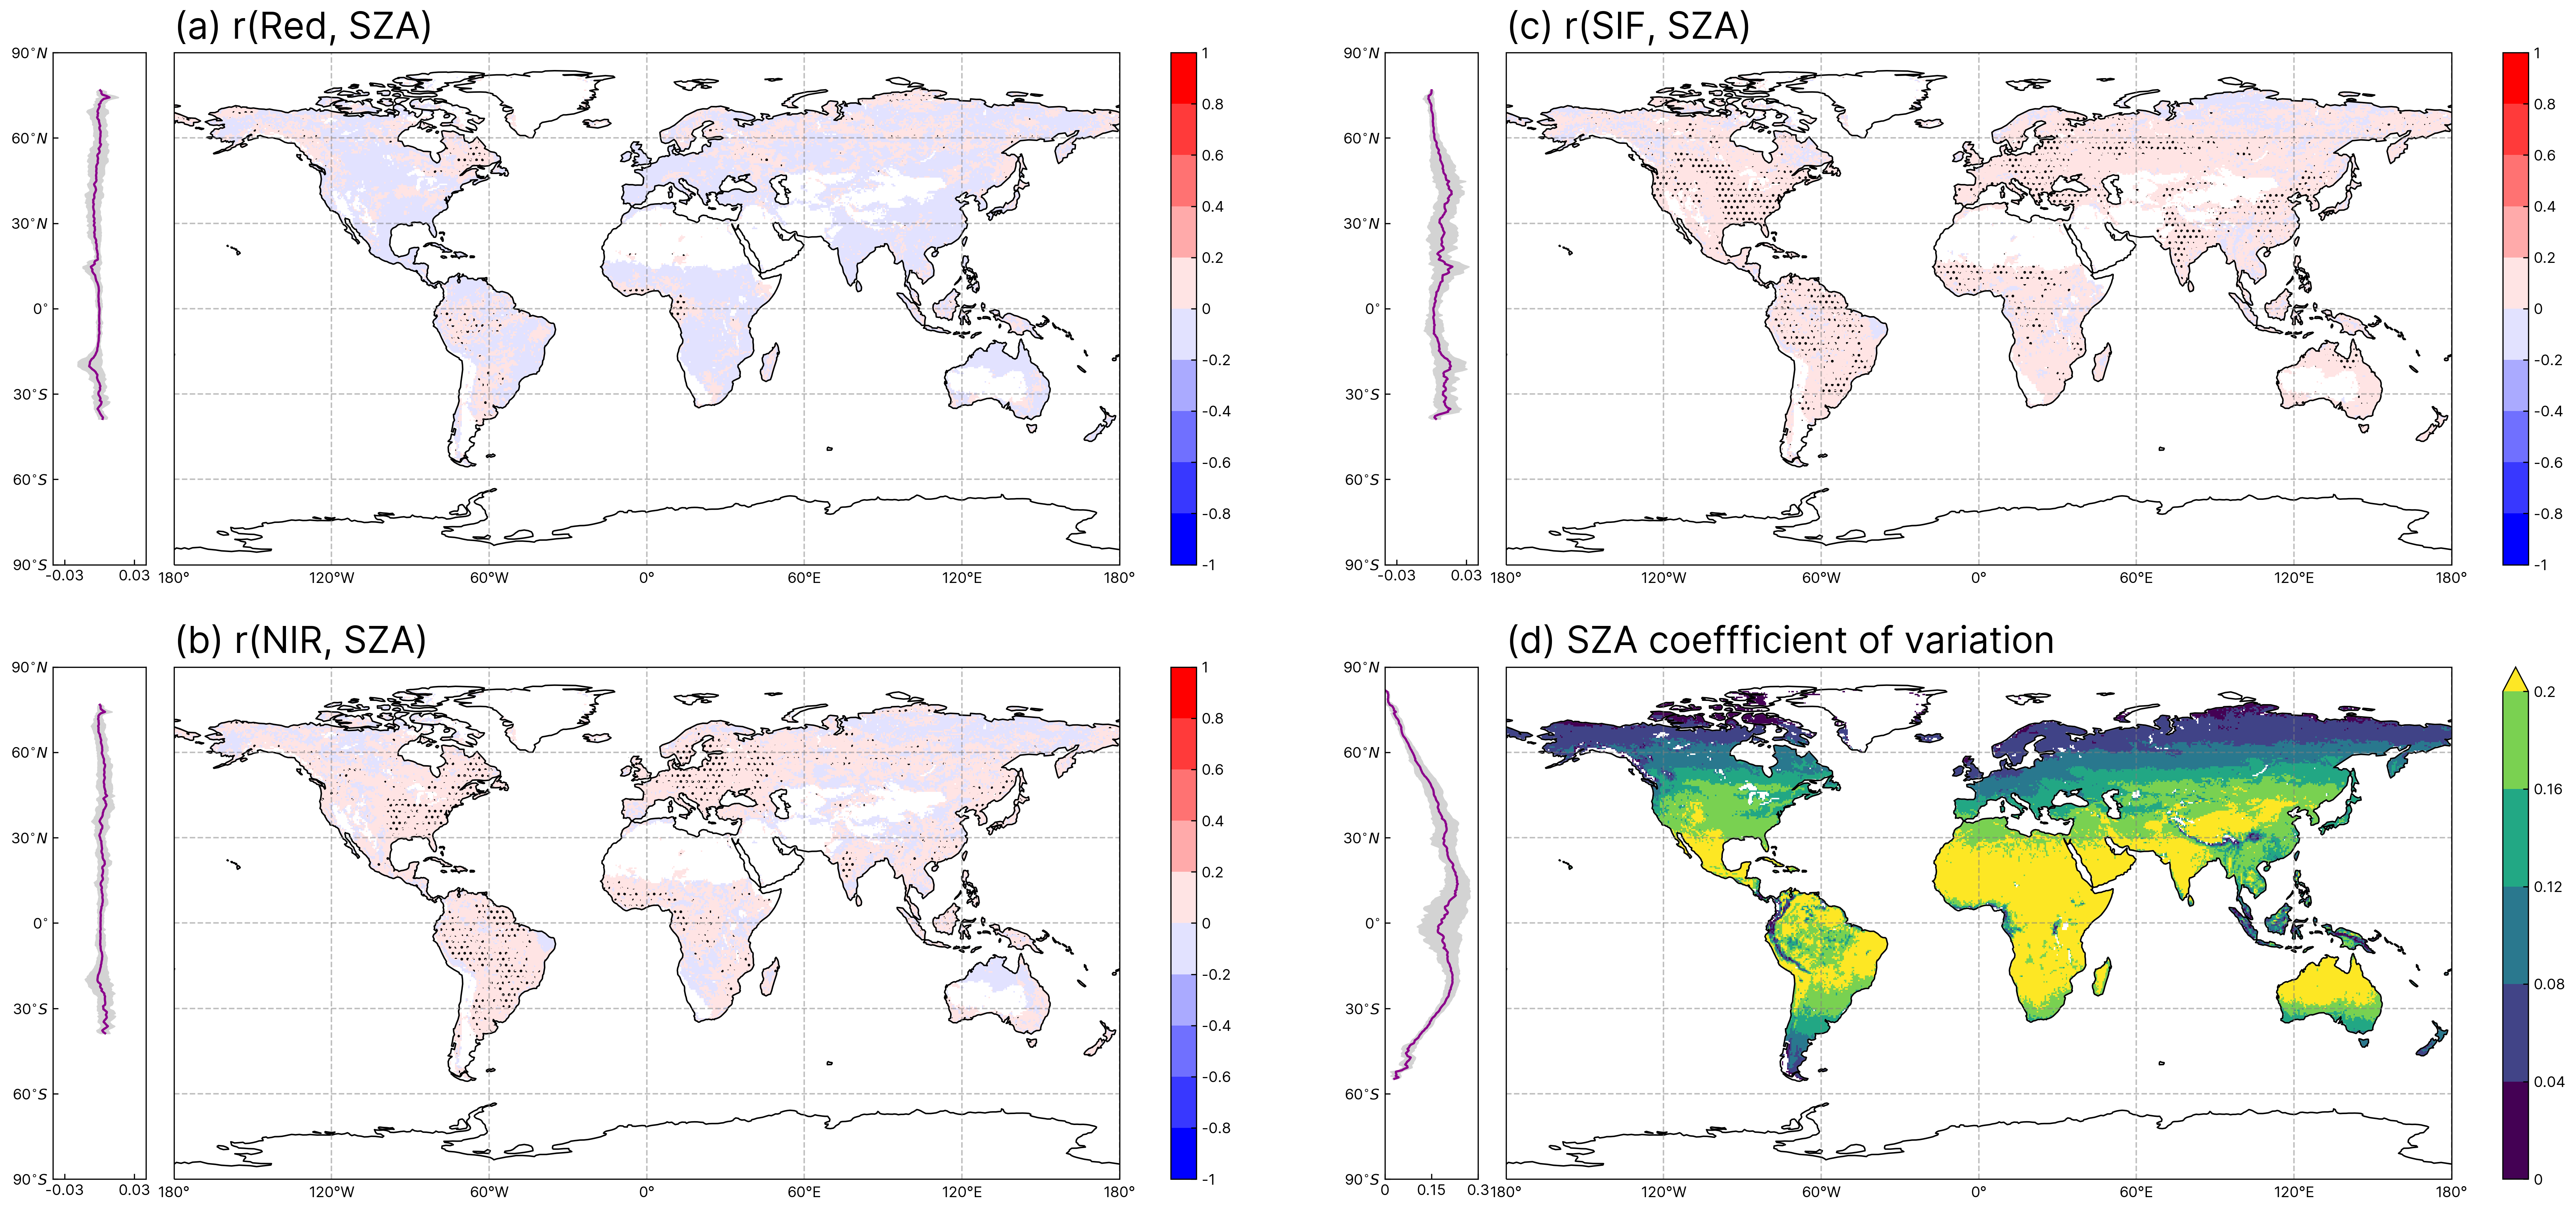

In [20]:
from matplotlib import gridspec

sza_coeff_variation = np.nanstd(sza_avhrr_spatial_array, axis=0) / np.nanmean(sza_avhrr_spatial_array, axis=0)

f = plt.figure(figsize=(25,14), dpi=300)
gs1 = gridspec.GridSpec(2, 2, width_ratios=[0.2, 2.2],
                       height_ratios=[1, 1, ], wspace=0.02)
gs1.update(left=0.05, right=0.48, wspace=0.05)

ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[0, 1], projection=ccrs.PlateCarree())
plot_pattern(f, ax1, ax2, red_sza_avhrr_cov_masked, red_sza_avhrr_pval_masked, "(a) r(Red, SZA)", True)


ax3 = plt.subplot(gs1[1, 0])
ax4 = plt.subplot(gs1[1, 1], projection=ccrs.PlateCarree())

plot_pattern(f, ax3, ax4, nir_sza_avhrr_cov_masked, nir_sza_avhrr_pval_masked, "(b) r(NIR, SZA)", True)

gs2 = gridspec.GridSpec(2, 2, width_ratios=[0.2, 2.2],
                       height_ratios=[1,1], wspace=0.02)
gs2.update(left=0.55, right=0.98, wspace=0.05)

ax5 = plt.subplot(gs2[0, 0])
ax6 = plt.subplot(gs2[0, 1], projection=ccrs.PlateCarree())

plot_pattern(f, ax5, ax6, sif_sza_avhrr_cov_masked, sif_sza_avhrr_pval_masked, "(c) r(SIF, SZA)", True)

ax7 = plt.subplot(gs2[1, 0])
ax8 = plt.subplot(gs2[1,1], projection=ccrs.PlateCarree())

plot_pattern(f, ax7, ax8, sza_coeff_variation, None, "(d) SZA coeffficient of variation",
             False, bound_norm_list=[0, 0.04, 0.08, 0.12, 0.16, 0.2], bound_norm_tick=[0, 0.04, 0.08, 0.12, 0.16, 0.2],
             bound_norm_tick_label=["0", "0.04", "0.08", "0.12", "0.16", "0.2"], lat_xlim=[0, 0.3], lat_norm_tick=[0, 0.15, 0.3], lat_norm_tick_label=["0", "0.15", "0.3"])


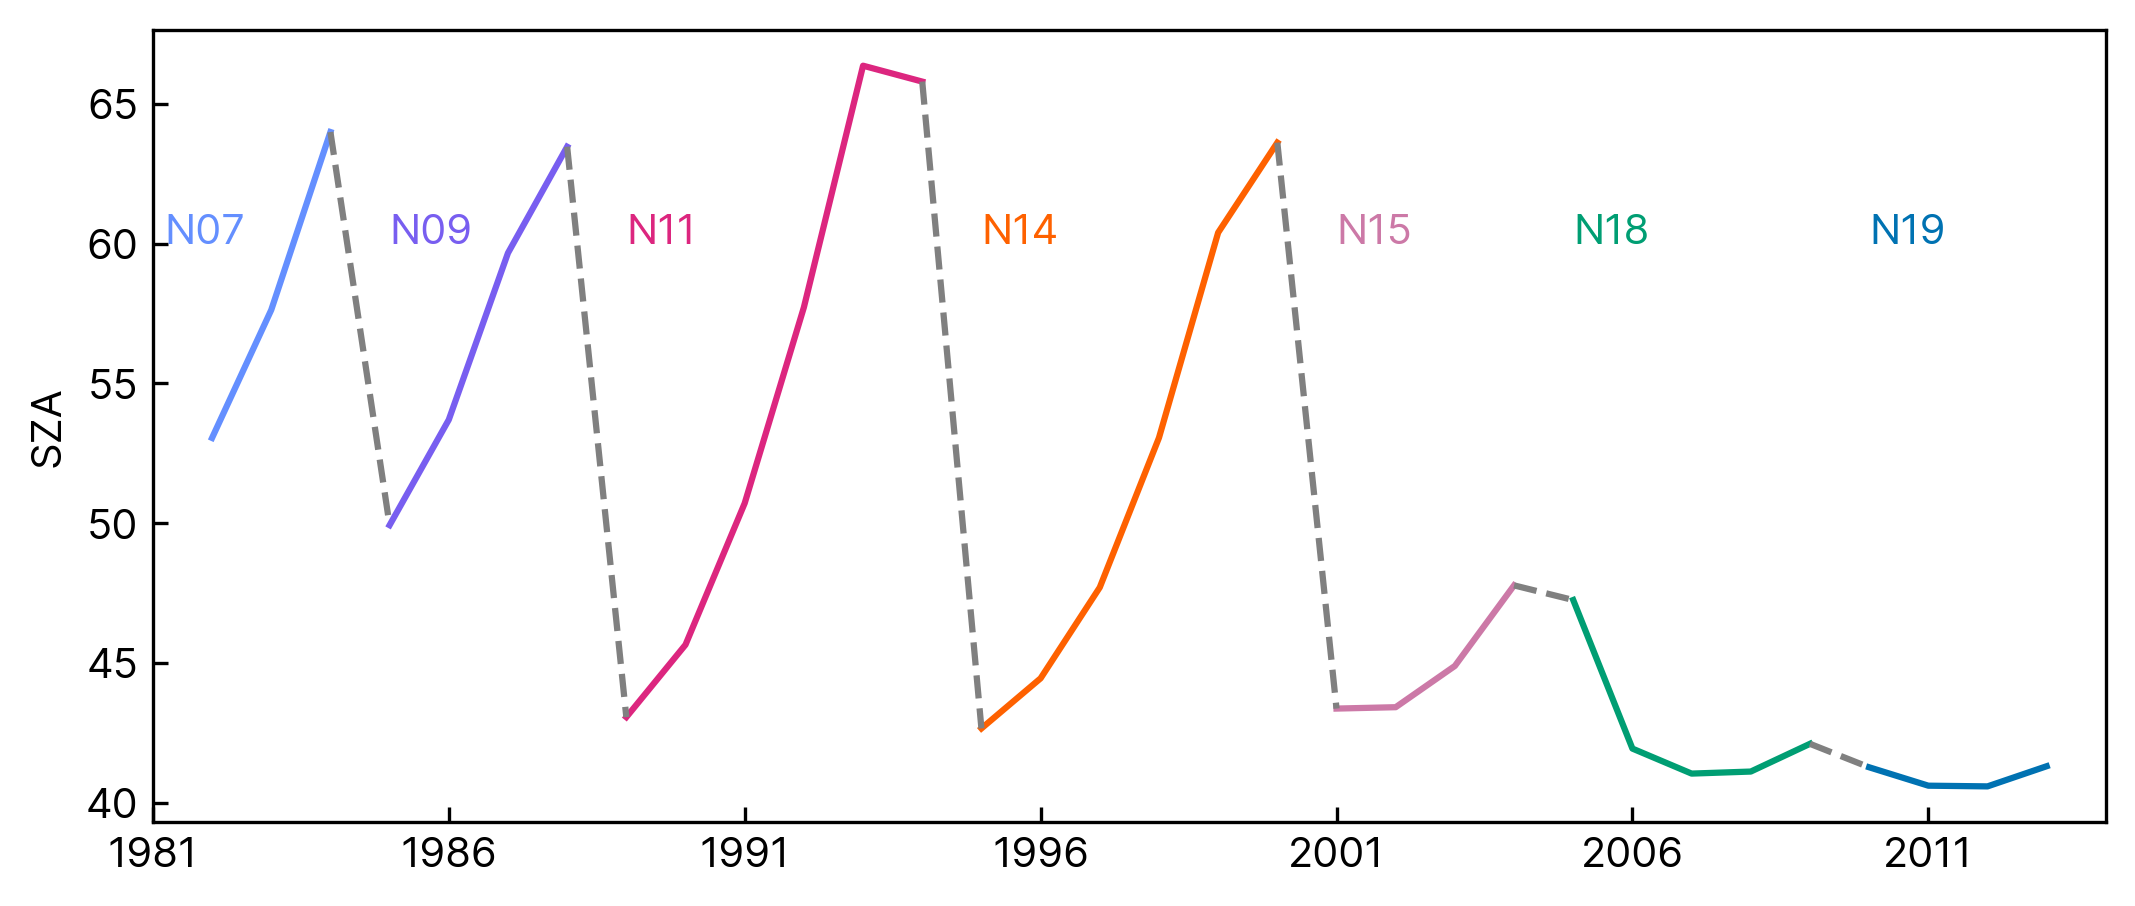

In [21]:
plt.figure(figsize=(8.4,3.5), dpi=300)


plt.plot(np.arange(1982, 2014)[0:3], sza_weighted_spatial_annual_mean_list[0:3], c="#648FFF", label="N07")
plt.text(1981.2, 60, "N07", c="#648FFF")
plt.plot(np.arange(1982, 2014)[3:7], sza_weighted_spatial_annual_mean_list[3:7], c="#785EF0", label="N09")
plt.text(1985, 60, "N09", c="#785EF0")
plt.plot(np.arange(1982, 2014)[7:13], sza_weighted_spatial_annual_mean_list[7:13], c="#DC267F", label="N11")
plt.text(1989, 60, "N11", c="#DC267F")
plt.plot(np.arange(1982, 2014)[13:19], sza_weighted_spatial_annual_mean_list[13:19], c="#FE6100", label="N14")
plt.text(1995, 60, "N14", c="#FE6100")
plt.plot(np.arange(1982, 2014)[19:23], sza_weighted_spatial_annual_mean_list[19:23], c="#CC79A7", label="N15")
plt.text(2001, 60, "N15", c="#CC79A7")
plt.plot(np.arange(1982, 2014)[23:28], sza_weighted_spatial_annual_mean_list[23:28], c="#009E73", label="N18")
plt.text(2005, 60, "N18", c="#009E73")
plt.plot(np.arange(1982, 2014)[28:], sza_weighted_spatial_annual_mean_list[28:], c="#0072B2", label="N19")
plt.text(2010, 60, "N19", c="#0072B2")

plt.plot(np.arange(1982, 2014)[2:4], sza_weighted_spatial_annual_mean_list[2:4], c="grey", linestyle="--")
plt.plot(np.arange(1982, 2014)[6:8], sza_weighted_spatial_annual_mean_list[6:8], c="grey", linestyle="--")
plt.plot(np.arange(1982, 2014)[12:14], sza_weighted_spatial_annual_mean_list[12:14], c="grey", linestyle="--")
plt.plot(np.arange(1982, 2014)[18:20], sza_weighted_spatial_annual_mean_list[18:20], c="grey", linestyle="--")
plt.plot(np.arange(1982, 2014)[22:24], sza_weighted_spatial_annual_mean_list[22:24], c="grey", linestyle="--")
plt.plot(np.arange(1982, 2014)[27:29], sza_weighted_spatial_annual_mean_list[27:29], c="grey", linestyle="--")


plt.ylabel("SZA")
plt.xticks([1981, 1986, 1991, 1996, 2001, 2006, 2011, 2016], ["1981", "1986", "1991", "1996", "2001", "2006", "2011", "2016"])
plt.xlim(1981, 2014)
plt.show()

In [35]:
plt.figure(dpi=300)
SZA_DIR = "AVHRR/data/SZA/"
SZA_FILES = sorted(os.listdir(SZA_DIR))
SZA = np.zeros((3600, 7200))

for f in SZA_FILES[0:240]:
    SZA += xr.open_dataset(os.path.join(SZA_DIR, f)).sza.values[0, :, :]
#plt.imshow(xr.open_dataset("AVHRR/data/SZA/SZA_200808a.nc").sza[0, :, :], 
#           interpolation="none"
#          )#plt.imshow("AVHRR/data/SZA/SZA_199107a.nc")

<Figure size 1500x1500 with 0 Axes>

In [91]:
files = [f for f in sorted(os.listdir("AVHRR/data/LTDR/N09/")) if ".hdf" in f]

In [230]:
plt.figure(dpi=300)
SZA_DIR = "AVHRR/data/LTDR/N09/"
SZA_FILES = sorted(os.listdir(SZA_DIR))
SZA = np.zeros((3600, 7200))
SZA_count = np.zeros((3600, 7200))

for f in tqdm(files[0:305]):
    SSS = rxr.open_rasterio(os.path.join(SZA_DIR, f)).SZEN[0, :, :].values.astype(np.float32)
    SSS[SSS==-9999]=0
    SSS = SSS * 0.01
    SZA += SSS
    SZA_count += (SSS>0)
    
#plt.imshow(xr.open_dataset("AVHRR/data/SZA/SZA_200808a.nc").sza[0, :, :], 
#           interpolation="none"
#          )#plt.imshow("AVHRR/data/SZA/SZA_199107a.nc")

100%|█████████████████████████████████████████| 305/305 [04:25<00:00,  1.15it/s]


<Figure size 1500x1500 with 0 Axes>

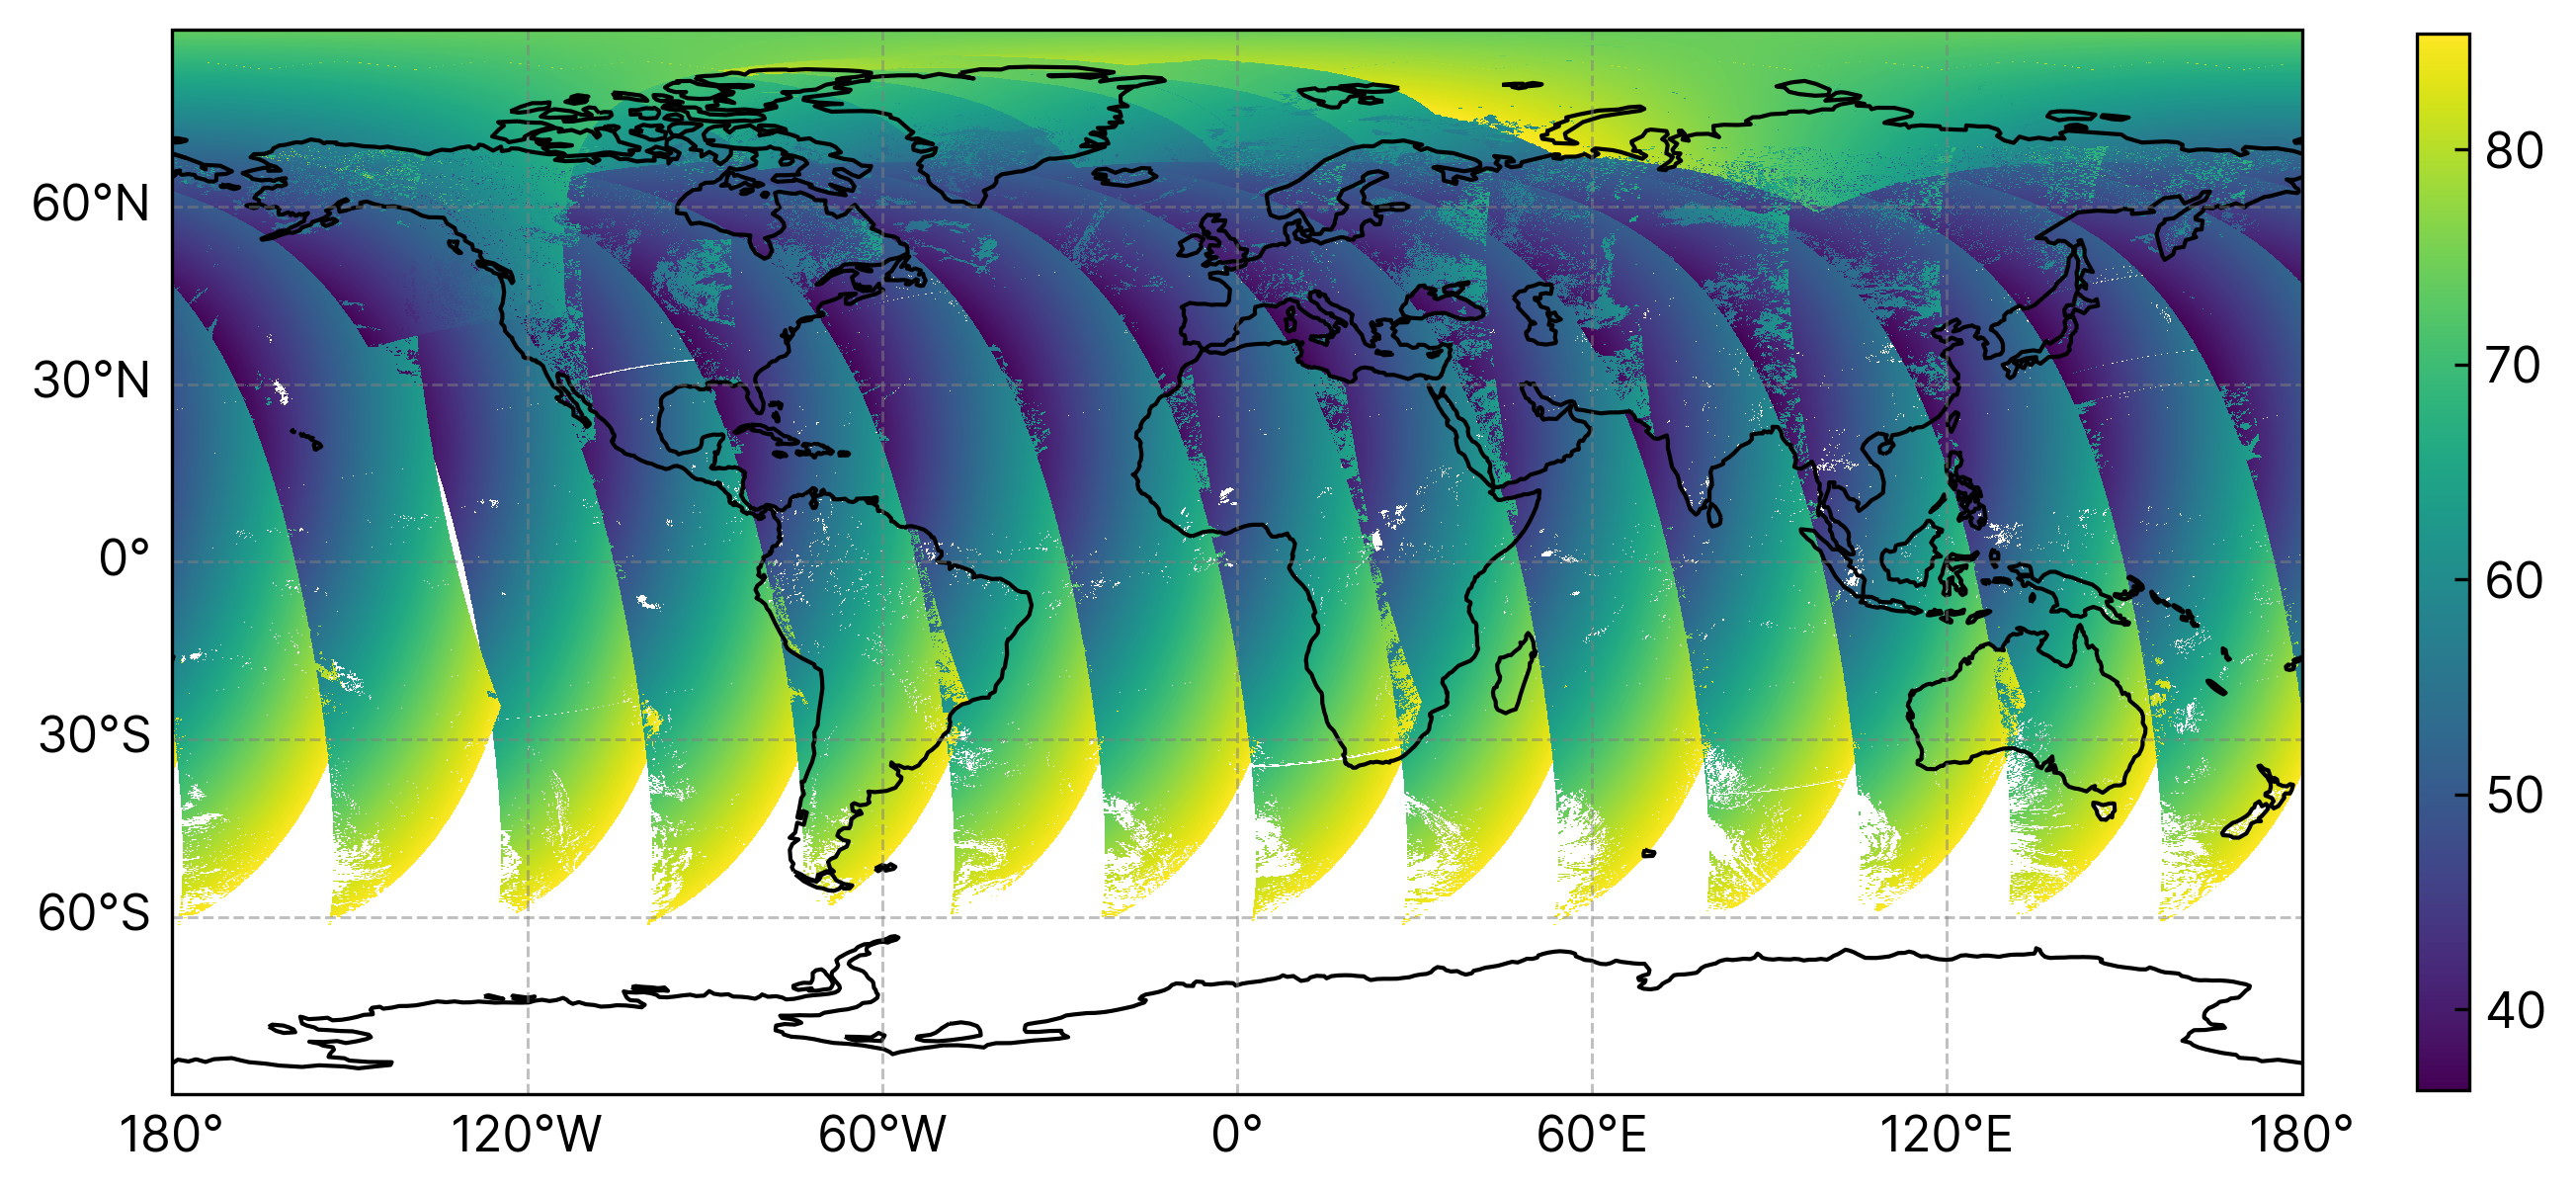

In [229]:
SZA_DIR = "AVHRR/data/LTDR/N09/"
SZA_FILES = sorted(os.listdir(SZA_DIR))


f = files[123]
SSS = rxr.open_rasterio(os.path.join(SZA_DIR, f)).SZEN[0, :, :].values.astype(np.float32)
SSS[SSS==-9999]=0
SSS = SSS * 0.01


fig = plt.figure(dpi=300, figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.PlateCarree())


def plot_pattern_sza(fig, ax2, data_mat, p_val, text_str, cor=False, bound_norm_list=None, bound_norm_tick=None, bound_norm_tick_label=None, lat_xlim=None, lat_norm_tick=None, lat_norm_tick_label=None):
    #count_too_small = 720 - np.sum(np.isnan(data_mat), axis=1) < 25
        

    data_mat[data_mat==0] = np.nan
    im2=ax2.imshow(data_mat, transform=ccrs.PlateCarree(), aspect=1, extent=[-180,180,-90,90],interpolation="none")
    cbar = plt.colorbar(im2, ax=ax2, orientation="vertical", fraction=0.023)
        
  
    gl=ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.right_labels=False
    gl.top_labels=False
    gl.left_labels=True
    ax2.coastlines()

    
plot_pattern_sza(f, ax, SSS, None, "")


/local/ipykernel_2476883/54706544.py:3: RuntimeWarning: invalid value encountered in divide
  plot_pattern_sza(f, ax, SZA/SZA_count, None, "")


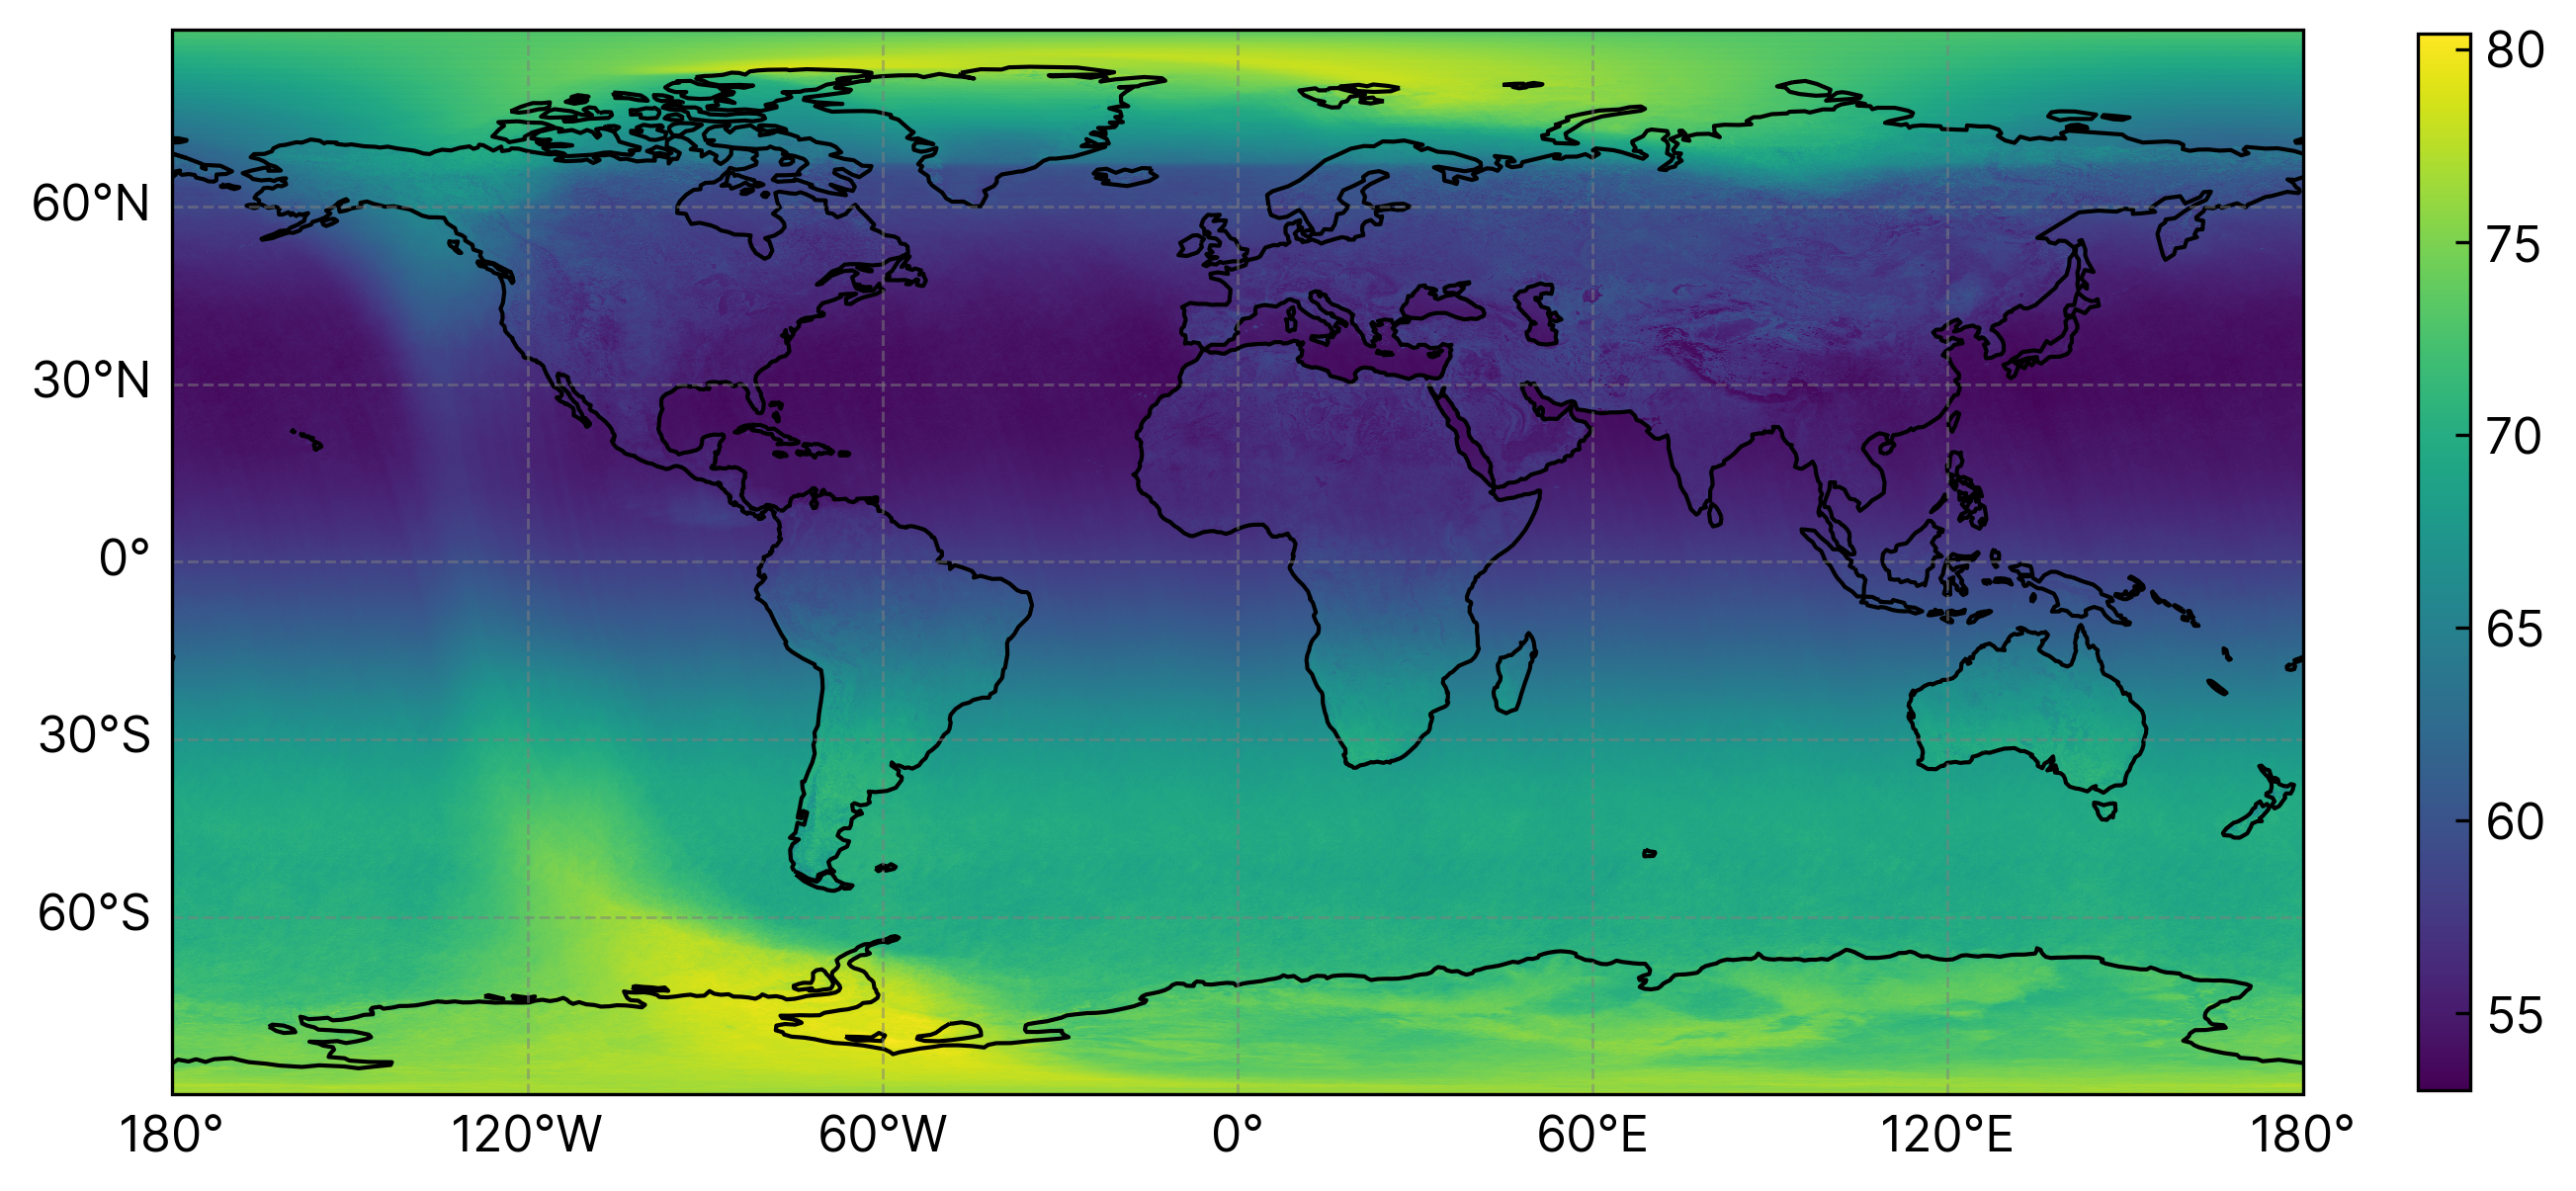

In [231]:
fig = plt.figure(dpi=300, figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
plot_pattern_sza(f, ax, SZA/SZA_count, None, "")
